## This notebook explores fuel types and the volumes of cargo transfered by fuel type


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
from monte_carlo_utils import decimal_divide
from pathlib import Path

In [2]:
# unit conversions
gal2m3 = 0.00378541

In [3]:
# User inputs
file_dir  = '/Users/rmueller/Data/MIDOSS/DeptOfEcology/'
file_name = 'MuellerTrans4-30-20.xlsx'
# location of output fro excel spreadsheets
output_directory = Path('/Users/rmueller/Data/MIDOSS/DeptOfEcology/')

# This is the precision used to calculate oil type weights 
# Trial and error showed that a precision of 2 is neccessary for weights
# to sum to 1.0
precision = 2

# Import columns are: (G) Deliverer, (H) Receiver, (O) Region, (P) Product, 
#                     (Q) Quantity in Gallons, (R) Transfer Type (Fueling, Cargo, or Other)', 
#                     (w) DelivererTypeDescription, (x) ReceiverTypeDescription 
df = pd.read_excel(f'{file_dir}{file_name}',sheet_name='Vessel Oil Transfer', 
               usecols="G,H,P,Q,R,W,X")
[nrows,ncols] = df.shape

In [4]:
# The following list includes facilities used in Casey's origin/destination analysis 
# with names matching the Dept. of Ecology (DOE) database.  
# For example, the shapefile "Maxum Petroleum - Harbor Island Terminal" is labeled as 'Maxum (Rainer Petroleum)'
# in the DOE database.  I use the Ecology language here and will need to translate to Shapefile speak 
facility_names = [ 'BP Cherry Point Refinery', 'Shell Puget Sound Refinery', 'Shell Oil LP Seattle Distribution Terminal',
                   'Maxum (Rainer Petroleum)', 'Tidewater Snake River Terminal','Nustar Energy Tacoma', 
                   'SeaPort Sound Terminal', 'Tesoro Vancouver Terminal','Phillips 66 Ferndale Refinery', 
                   'Phillips 66 Tacoma Terminal', 'Andeavor Anacortes Refinery (formerly Tesoro)',
                   'Tesoro Port Angeles Terminal','U.S. Oil & Refining','US Oil Tacoma ','Naval Air Station Whidbey Island (NASWI)',
                   'NAVSUP Manchester', 'Alon Asphalt Company (Paramount Petroleum)', 'Kinder Morgan Liquids Terminal - Harbor Island',
                   'Nustar Energy Tacoma', 'Tesoro Pasco Terminal', 'REG Grays Harbor, LLC', 'Tidewater Vancouver Terminal',
                   'TLP','TLP Management Services LLC (TMS)']

## Initialize lists and dictionaries 

In [5]:
other_import = []
other_export = []
dilbit_receiver = []
dilbit_deliverer = []

# volume of oil cargo transfers by oil type
volume = {}
volume['total'] = 0
volume['other'] = 0
volume['crude'] = 0
volume['bunker'] = 0
volume['gas'] = 0
volume['jet'] = 0
volume['diesel'] = 0
volume['bitumen'] = 0

# number of transfers (includes both import and export)
transfers = {}
transfers['total'] = 0
transfers['other'] = 0
transfers['crude'] = 0
transfers['bunker'] = 0
transfers['gas'] = 0
transfers['jet'] = 0
transfers['diesel'] =0
transfers['bitumen'] = 0

# catalogue names of oils used by DOE that are represented 
# in each of our categories
names = {}
names['other'] = []
names['crude'] = []
names['bunker'] = []
names['gas'] = []
names['jet'] = []
names['diesel'] = []
names['bitumen'] = []

# tally transfers and crude imports/exports by facility
transfers_byloc = {}
volume_byloc={}
for facility in facility_names:
    transfers_byloc[facility] = 0
    volume_byloc[facility] = 0

## Add volume transfers and define fuel types

In [6]:
for row in range(nrows):
    
    # ~~~~~~~ COMBINED IMPORTS AND EXPORTS ~~~~~~~
    if (df.Receiver[row] in facility_names or
        df.Deliverer[row] in facility_names and 
        df.TransferType[row] == 'Cargo'
       ):
               
        # ~~~~~~ Catalogue names ~~~~~~~~~~~~~~~~~
        if ('CRUDE' in df.Product[row] and 
            df.Product[row] not in names['crude']
           ):
            names['crude'].append(df.Product[row])
        elif ('BUNKER OIL/HFO' in df.Product[row] and 
            df.Product[row] not in names['bunker']
           ):
            names['bunker'].append(df.Product[row])
        elif ('GASOLINE' in df.Product[row] and 
            df.Product[row] not in names['gas']
           ):
            names['gas'].append(df.Product[row])
        elif ('JET FUEL/KEROSENE' in df.Product[row] and 
            df.Product[row] not in names['jet']
           ):
            names['jet'].append(df.Product[row])
        elif ('DIESEL' in df.Product[row] and 
            df.Product[row] not in names['diesel']
           ):
            names['diesel'].append(df.Product[row])
        # OTHER
        else:
            if (df.Product[row] not in names['other']):
                names['other'].append(df.Product[row])
            
        # ~~~~~~ Tally volume and transfers ~~~~~~~~~~~
        transfers['total'] += 1 
        volume['total'] += df.TransferQtyInGallon[row]
        
        if ('CRUDE' in df.Product[row]):
            volume['crude']+= df.TransferQtyInGallon[row]
            transfers['crude'] += 1
        elif ('BUNKER OIL/HFO' in df.Product[row]):
            volume['bunker']+= df.TransferQtyInGallon[row]
            transfers['bunker'] += 1
        elif ('GASOLINE' in df.Product[row]):
            volume['gas']+= df.TransferQtyInGallon[row]
            transfers['gas'] += 1
        elif ('JET FUEL/KEROSENE' in df.Product[row]):
            volume['jet']+= df.TransferQtyInGallon[row]
            transfers['jet'] += 1
        elif ('DIESEL' in df.Product[row]):
            volume['diesel']+= df.TransferQtyInGallon[row]
            transfers['diesel'] += 1
        elif ('BITUMEN OIL (DIL OR SYN)' in df.Product[row]):
            volume['bitumen']+= df.TransferQtyInGallon[row]
            transfers['bitumen'] += 1
            if df.Receiver[row] not in dilbit_receiver:
                dilbit_receiver.append(df.Receiver[row])
            if df.Deliverer[row] not in dilbit_deliverer:
                dilbit_deliverer.append(df.Deliverer[row])
        # OTHER
        else:
            volume['other']+= df.TransferQtyInGallon[row]
            transfers['other'] += 1
            
        # ~~~~~~ Tally transfers by terminal ~~~~~~~~~~~  
        if (df.Receiver[row] in facility_names):
            transfers_byloc[df.Receiver[row]] += 1
            volume_byloc[df.Receiver[row]] += df.TransferQtyInGallon[row]
        elif (df.Deliverer[row] in facility_names):
            transfers_byloc[df.Deliverer[row]] += 1
            volume_byloc[df.Deliverer[row]] += df.TransferQtyInGallon[row]
    
    # ~~~~~~~~~~~~~~~ IMPORTS ~~~~~~~~~~~~~~~~~~~~
    # Catalogue fuel imports (destination traffic)
    if (df.Receiver[row] in facility_names and 
        df.TransferType[row] == 'Cargo'
       ):      
               
        # "Other" fuel-type imports 
        if ('CRUDE' not in df.Product[row] and 
            'BUNKER OIL/HFO' not in df.Product[row] and 
            'GASOLINE' not in df.Product[row] and
            'JET FUEL/KEROSENE' not in df.Product[row] and
            'DIESEL' not in df.Product[row]
           ):
            if df.Product[row] not in other_import:
                other_import.append(df.Product[row])
    
    # ~~~~~~~~~~~~~~~ EXPORTS ~~~~~~~~~~~~~~~~~~~~
    # Catalogue fuel exports 
    if (df.Deliverer[row] in facility_names and 
        df.TransferType[row] == 'Cargo'
       ):        
        
        # "Other" fuel-type exports 
        if ('CRUDE' not in df.Product[row] and 
            'BUNKER OIL/HFO' not in df.Product[row] and 
            'GASOLINE' not in df.Product[row] and
            'JET FUEL/KEROSENE' not in df.Product[row] and
            'DIESEL' not in df.Product[row] 
           ):
            if df.Product[row] not in other_export:
                other_export.append(df.Product[row])
            

#### Tally volume transferred for 'other' fuel types

In [7]:
# for some reason, the above list is incomplete.  It's missing hydraulic oil
other = {}
other['types'] = []
# make complete list of "other" oil types
for row in range(nrows):   
    # ~~~~~~~ COMBINED IMPORTS AND EXPORTS ~~~~~~~
    if (df.Receiver[row] in facility_names or
        df.Deliverer[row] in facility_names and 
        df.TransferType[row] == 'Cargo'
       ):
        # "Other" fuel-type exports 
        if ('CRUDE' not in df.Product[row] and 
            'BUNKER OIL/HFO' not in df.Product[row] and 
            'GASOLINE' not in df.Product[row] and
            'JET FUEL/KEROSENE' not in df.Product[row] and
            'DIESEL' not in df.Product[row] 
           ):
            if df.Product[row] not in other['types']:
                other['types'].append(df.Product[row])
               
other['types']

['Cat Feed/VGO',
 'ETHANOL',
 'CUTTER STOCK',
 'OILY WASTE',
 'WASTE OIL',
 'NAPTHA',
 'Z-OTHER',
 'EDIBLE/VEGETABLE OIL',
 'DECANT OIL',
 'NONENE',
 'LUBE OIL/MOTOR OIL',
 'BITUMEN OIL (DIL OR SYN)',
 'HYDRAULIC OIL',
 'USED OIL',
 'BAKKEN',
 'ASPHALT/CREOSEOTE']

In [8]:
other['volume_gallons'] = np.zeros(len(other['types']))
other['transfers'] = np.zeros(len(other['types']))

# Now use name of "other" product to find index for tallying volumes and transfers
for row in range(nrows):   
    # ~~~~~~~ COMBINED IMPORTS AND EXPORTS ~~~~~~~
    if (df.Receiver[row] in facility_names or
        df.Deliverer[row] in facility_names and 
        df.TransferType[row] == 'Cargo'
       ):
        # "Other" fuel-type exports 
        if ('CRUDE' not in df.Product[row] and 
            'BUNKER OIL/HFO' not in df.Product[row] and 
            'GASOLINE' not in df.Product[row] and
            'JET FUEL/KEROSENE' not in df.Product[row] and
            'DIESEL' not in df.Product[row] 
           ):
            oil_index = other['types'].index(df.Product[row])
            other['volume_gallons'][oil_index] += df.TransferQtyInGallon[row]
            other['transfers'][oil_index] += 1
            
other['volume_m3'] = [gal2m3 * volume for volume in other['volume_gallons']]


### Create dataframe for viewing and exporting

#### by oil types

In [9]:
# create dataframe from dictionary
oil_type_transfers = pd.DataFrame(data=transfers,index=[1])
oil_type_volume = pd.DataFrame(data=volume,index=[0])
# dataframe with oil types as columns
oil_type_cols = oil_type_transfers.append(oil_type_volume)
oil_type_cols.index = ['transfers','volume_gallons']

# dataframe with oil types as rows
oil_type = oil_type_cols.transpose().sort_values(by=['volume_gallons'], ascending=False).copy()

# convert from gallons to m3 (and keep both for reference)
oil_type['volume_m3'] = [ (gal2m3 * volume) for volume in oil_type['volume_gallons']]
net_volume = oil_type['volume_m3'][0]

# Add volume/transfers to dataframe
m3_per_transfer = [volume/transfers for volume,transfers in zip(oil_type['volume_m3'],oil_type['transfers'])]
oil_type['m3_per_transfer'] = m3_per_transfer

oil_type['percent_total'] = [volume/oil_type['volume_m3'][0] for volume in oil_type['volume_m3']]
oil_type.to_excel(output_directory/"oiltype_transfers.xlsx", sheet_name='oil_types')
oil_type

,transfers,volume_gallons,volume_m3,m3_per_transfer,percent_total
total,4484,9999837173,3.785348e+07,8441.900899,1.000000
crude,311,4077068048,1.543337e+07,49624.997298,0.407713
gas,817,1853731888,7.017135e+06,8588.904806,0.185376
diesel,1202,1331394934,5.039876e+06,4192.908234,0.133142
bunker,1273,1265634411,4.790945e+06,3763.507585,0.126566
other,495,845205506,3.199449e+06,6463.534090,0.084522
jet,380,623700774,2.360963e+06,6213.060913,0.062371
bitumen,6,3101612,1.174087e+04,1956.812180,0.000310


1.0

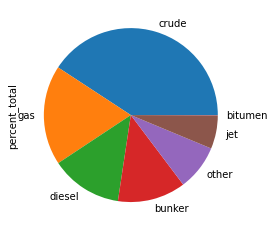

In [10]:
plot_oil_type = oil_type.drop('total')
plot_oil_type['percent_total'].plot.pie()
plot_oil_type['percent_total'].sum()

##### show volumes for "other" oil types

#### by facility

In [11]:
# create dataframe from dictionary
facility_transfers = pd.DataFrame(data=transfers_byloc,index=[0])
facility_volumes = pd.DataFrame(data=volume_byloc,index=[1])
# dataframe with facilities as columns
facility_cols = facility_transfers.append(facility_volumes)
facility_cols.index = ['transfers','volume_gallons']
# dataframe with facilities as rows
facility = facility_cols.transpose().sort_values(by=['volume_gallons'], ascending=False).copy()

# Housekeeping for multiple names in the case of TLP and US Oil
# Although I get a key error for 'US Oil Tacoma that I don't understand
#facility.loc['U.S. Oil & Refining',:] = facility.loc[['US Oil Tacoma','U.S. Oil & Refining']].sum(axis=0)
#facility.drop(['US Oil Tacoma'], inplace=True)

facility.loc['TLP Management Services LLC (TMS)',:] = facility.loc[['TLP','TLP Management Services LLC (TMS)']].sum(axis=0)
facility.drop(['TLP'], inplace=True)

facility['volume_m3'] = [(gal2m3 * volume) for volume in facility['volume_gallons']]
# Add volume/transfers to dataframe
facility['m3_per_transfer'] = [volume/transfer for volume,transfer in zip(facility['volume_m3'],facility['transfers'])]
facility['percent_total_volume'] = [100*volume/net_volume for volume in facility['volume_m3']]


# format output
format_mapping={'transfers':'{:,.0f}', 'volume_gallons':'{:.2E}', 'volume_m3':'{:.2E}', 'm3_per_transfer':'{:.2E}', 'percent_total_volume':'{:.2f}%'}
for key, value in format_mapping.items():
    facility[key] = facility[key].apply(value.format)

facility.to_excel(output_directory/"facility_transfers.xlsx", sheet_name='facility') 
facility

,transfers,volume_gallons,volume_m3,m3_per_transfer,percent_total_volume
BP Cherry Point Refinery,543,3.56E+09,1.35E+07,2.48E+04,35.63%
Shell Puget Sound Refinery,408,2.00E+09,7.56E+06,1.85E+04,19.97%
Andeavor Anacortes Refinery (formerly Tesoro),425,1.28E+09,4.85E+06,1.14E+04,12.82%
Phillips 66 Ferndale Refinery,638,1.25E+09,4.74E+06,7.43E+03,12.52%
SeaPort Sound Terminal,410,3.81E+08,1.44E+06,3.52E+03,3.81%
U.S. Oil & Refining,258,2.90E+08,1.10E+06,4.25E+03,2.90%
Alon Asphalt Company (Paramount Petroleum),451,2.89E+08,1.09E+06,2.42E+03,2.89%
Tidewater Snake River Terminal,244,2.44E+08,9.23E+05,3.78E+03,2.44%
Kinder Morgan Liquids Terminal - Harbor Island,257,1.98E+08,7.49E+05,2.91E+03,1.98%
Tesoro Pasco Terminal,112,1.08E+08,4.08E+05,3.64E+03,1.08%


In [12]:
# Why am I getting a key error for "US Oil Tacoma" when it's clearly there?
facility[20:]

,transfers,volume_gallons,volume_m3,m3_per_transfer,percent_total_volume
US Oil Tacoma,2,2.10E+06,7.95E+03,3.97E+03,0.02%
Tidewater Vancouver Terminal,5,4.90E+03,1.85E+01,3.71E+00,0.00%


### for other oil types

In [13]:
# create dataframe from dictionary
other_transfers = pd.DataFrame(data=other)
other_transfers['percent_other_volume'] = [100*volume/other_transfers['volume_m3'].sum() for volume in other_transfers['volume_m3']]
other_transfers['percent_all_volume'] = [100*volume/net_volume for volume in other_transfers['volume_m3']]
other_transfers.sort_values(by=['volume_m3'],ascending=False)
other_transfers.to_excel(output_directory/"other_transfers.xlsx", sheet_name='other_oiltype')
# format output
format_mapping={'transfers':'{:,.0f}', 'volume_gallons':'{:.2E}', 'volume_m3':'{:.2E}', 'percent_other_volume':'{:.2f}%',  'percent_all_volume':'{:.2f}%'}
for key, value in format_mapping.items():
    other_transfers[key] = other_transfers[key].apply(value.format)
other_transfers.set_index('types')

,volume_gallons,transfers,volume_m3,percent_other_volume,percent_all_volume
types,,,,,
Cat Feed/VGO,4.44E+08,119,1.68E+06,52.31%,4.44%
ETHANOL,1.05E+08,83,3.99E+05,12.42%,1.05%
CUTTER STOCK,7.90E+07,107,2.99E+05,9.31%,0.79%
OILY WASTE,9.30E+06,16,3.52E+04,1.10%,0.09%
WASTE OIL,1.24E+06,10,4.70E+03,0.15%,0.01%
NAPTHA,6.72E+07,16,2.55E+05,7.93%,0.67%
Z-OTHER,6.43E+07,62,2.43E+05,7.58%,0.64%
EDIBLE/VEGETABLE OIL,1.78E+07,4,6.74E+04,2.10%,0.18%
DECANT OIL,4.90E+07,31,1.86E+05,5.78%,0.49%


In [14]:
other_import

['CUTTER STOCK',
 'OILY WASTE',
 'Cat Feed/VGO',
 'Z-OTHER',
 'EDIBLE/VEGETABLE OIL',
 'NAPTHA',
 'ETHANOL',
 'DECANT OIL',
 'WASTE OIL',
 'BAKKEN',
 'ASPHALT/CREOSEOTE']

In [15]:
other_export

['Cat Feed/VGO',
 'ETHANOL',
 'CUTTER STOCK',
 'NAPTHA',
 'DECANT OIL',
 'NONENE',
 'LUBE OIL/MOTOR OIL',
 'Z-OTHER',
 'BITUMEN OIL (DIL OR SYN)',
 'OILY WASTE']

In [16]:
dilbit_deliverer

['SeaPort Sound Terminal', 'Alon Asphalt Company (Paramount Petroleum)']

In [17]:
dilbit_receiver

['VIJAY SEA', 'DUGAN PEARSALL', 'OLYMPIC SPIRIT', 'WEBB MOFFETT']

## Well that's surprising!  
- SeaPort Sound Terminal has not yet crossed my radar in relation to Bitumen transport
- Bitumen not listed as import product to U.S. Oil (as expected)

### Also noteworthy is that the voyage data marine terminal transfers data does not reflect transfers for cargo alone. 
This section tests the hypothesis that the difference is caused by fueling

In [30]:
transfers_byloc_wfuel = {}
volume_byloc_wfuel = {}

for facility in facility_names:
    transfers_byloc_wfuel[facility] = 0
    volume_byloc_wfuel[facility] = 0

for row in range(nrows):
    
    # ~~~~~~~ COMBINED IMPORTS AND EXPORTS, FUEL AND CARGO ~~~~~~~
    if (df.Receiver[row] in facility_names or
        df.Deliverer[row] in facility_names
       ):
        
         # ~~~~~~ Tally transfers by terminal ~~~~~~~~~~~  
        if (df.Receiver[row] in facility_names):
            transfers_byloc_wfuel[df.Receiver[row]] += 1
            volume_byloc_wfuel[df.Receiver[row]] += df.TransferQtyInGallon[row]
        elif (df.Deliverer[row] in facility_names):
            transfers_byloc_wfuel[df.Deliverer[row]] += 1
            volume_byloc_wfuel[df.Deliverer[row]] += df.TransferQtyInGallon[row]
            
            
# create dataframe from dictionary
facility_transfers = pd.DataFrame(
    data=transfers_byloc_wfuel,
    index=[0]
)
facility_volumes = pd.DataFrame(
    data=volume_byloc_wfuel,
    index=[1]
)
# dataframe with facilities as columns
facility_cols = facility_transfers.append(facility_volumes)
facility_cols.index = ['transfers','volume_gallons']

# dataframe with facilities as rows
facility_wfuel = facility_cols.transpose().sort_values(by=['transfers'], ascending=False).copy()

# Housekeeping for multiple names in the case of TLP and US Oil
# Although I get a key error for 'US Oil Tacoma that I don't understand
#facility.loc['U.S. Oil & Refining',:] = facility.loc[['US Oil Tacoma','U.S. Oil & Refining']].sum(axis=0)
#facility.drop(['US Oil Tacoma'], inplace=True)

facility_wfuel.loc['TLP Management Services LLC (TMS)',:] = facility_wfuel.loc[['TLP','TLP Management Services LLC (TMS)']].sum(axis=0)
facility_wfuel.drop(['TLP'], inplace=True)

facility_wfuel['volume_m3'] = [(gal2m3 * volume) for volume in facility_wfuel['volume_gallons']]
# Add volume/transfers to dataframe
facility_wfuel['m3_per_transfer'] = [volume/transfer for volume,transfer in zip(facility_wfuel['volume_m3'],facility_wfuel['transfers'])]
facility_wfuel['percent_total_volume'] = [100*volume/net_volume for volume in facility_wfuel['volume_m3']]
facility_wfuel.index.name = 'LOCATION'
facility_wfuel

,transfers,volume_gallons,volume_m3,m3_per_transfer,percent_total_volume
LOCATION,,,,,
Maxum (Rainer Petroleum),2761,49721268,1.882154e+05,68.169281,0.497221
Phillips 66 Ferndale Refinery,639,1252545000,4.741396e+06,7420.025616,12.525654
BP Cherry Point Refinery,543,3562469570,1.348541e+07,24835.005405,35.625276
Alon Asphalt Company (Paramount Petroleum),459,294087892,1.113243e+06,2425.366552,2.940927
SeaPort Sound Terminal,450,386426941,1.462784e+06,3250.632015,3.864332
Tidewater Snake River Terminal,445,247509050,9.369232e+05,2105.445467,2.475131
Andeavor Anacortes Refinery (formerly Tesoro),425,1281986324,4.852844e+06,11418.456119,12.820072
Shell Puget Sound Refinery,408,1997329772,7.560712e+06,18531.157089,19.973623
U.S. Oil & Refining,364,293530195,1.111132e+06,3052.560812,2.935350


In [31]:
# format output
format_mapping={'transfers':'{:,.0f}', 'volume_gallons':'{:.2E}', 'volume_m3':'{:.2E}', 'm3_per_transfer':'{:.2E}', 'percent_total_volume':'{:.2f}%'}
for key, value in format_mapping.items():
    facility_wfuel[key] = facility_wfuel[key].apply(value.format)

facility_wfuel.to_excel(output_directory/"facility_transfers_wfuel.xlsx", sheet_name='facility_wfuel') 


### Load Cam's data on number of voyages linked to WA marine terminals

In [45]:
CamSheet = '/Users/rmueller/Documents/Publications/SOILED_MuellerEtAl_paper1/Methods/origin-destination/Origin_Destination_Analysis.xlsx'
camdf = pd.read_excel(CamSheet,sheet_name="Voyage_Counts", 
               usecols="A,B")
camdf = camdf.set_index('LOCATION')
camdf = camdf.join(facility_wfuel.transfers, how='outer')
camdf

,TRANSFERS,transfers
LOCATION,,
Alon Asphalt Company (Paramount Petroleum),2382.0,459
Andeavor Anacortes Refinery (formerly Tesoro),NaN,425
BP Cherry Point Refinery,2574.0,543
Barge Mooring Near Stanovan,3639.0,NaN
Canada,9709.0,NaN
Chevron Cobble Hill,170.0,NaN
Chevron Stanovan,1852.0,NaN
ESSO IOCO Vancouver,1442.0,NaN
ESSO Nanaimo Departure Bay,309.0,NaN


In [61]:
camdf.columns = ['voyage_transfers', 'DOE_transfers']
camdf['DOE_transfers'] = camdf['DOE_transfers'].str.replace(",","").astype(float)
#camdf.reset_index(inplace=True)
camdf

,voyage_transfers,DOE_transfers
LOCATION,,
Alon Asphalt Company (Paramount Petroleum),2382.0,459.0
Andeavor Anacortes Refinery (formerly Tesoro),NaN,425.0
BP Cherry Point Refinery,2574.0,543.0
Barge Mooring Near Stanovan,3639.0,NaN
Canada,9709.0,NaN
Chevron Cobble Hill,170.0,NaN
Chevron Stanovan,1852.0,NaN
ESSO IOCO Vancouver,1442.0,NaN
ESSO Nanaimo Departure Bay,309.0,NaN


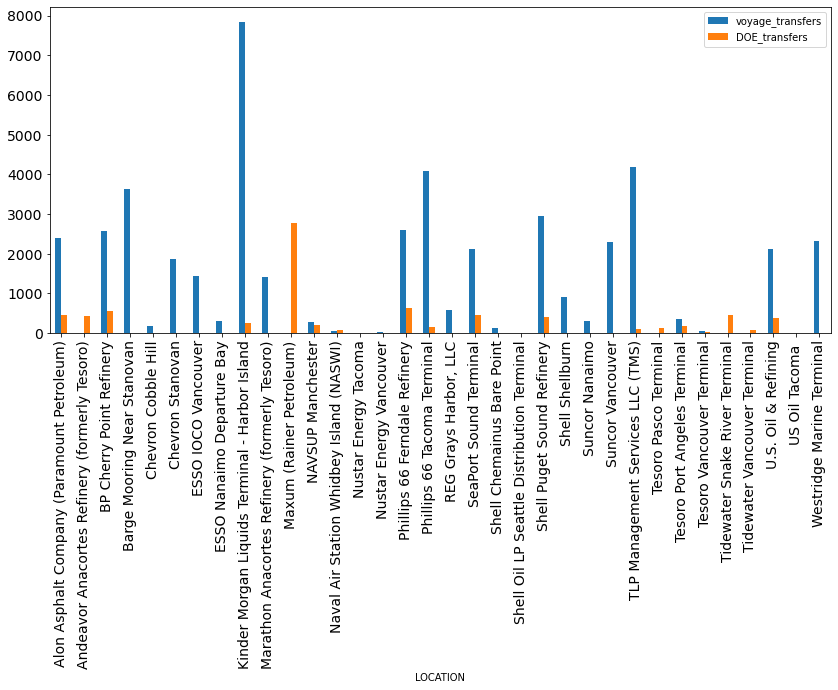

In [74]:
#camdf = camdf.drop('US')
camdf = camdf.drop('Pacific')
camdf = camdf.drop('Canada')
camdf.plot(y=['voyage_transfers', 'DOE_transfers'], kind = "bar",figsize=(14,6),fontsize=14)
plt.show()

In [41]:
camdf.index

Index(['Alon Asphalt Company (Paramount Petroleum)',
       'Andeavor Anacortes Refinery (formerly Tesoro)',
       'BP Cherry Point Refinery', 'Barge Mooring Near Stanovan', 'Canada',
       'Chevron Cobble Hill', 'Chevron Stanovan', 'ESSO IOCO Vancouver',
       'ESSO Nanaimo Departure Bay',
       'Kinder Morgan Liquids Terminal - Harbor Island',
       'Marathon Anacortes Refinery (formerly Tesoro)',
       'Maxum (Rainer Petroleum)', 'NAVSUP Manchester',
       'Naval Air Station Whidbey Island (NASWI)', 'Nustar Energy Tacoma',
       'Nustar Energy Vancouver', 'Pacific', 'Phillips 66 Ferndale Refinery',
       'Phillips 66 Tacoma Terminal', 'REG Grays Harbor, LLC',
       'SeaPort Sound Terminal', 'Shell Chemainus Bare Point',
       'Shell Oil LP Seattle Distribution Terminal',
       'Shell Puget Sound Refinery', 'Shell Shellburn', 'Suncor Nanaimo',
       'Suncor Vancouver', 'TLP Management Services LLC (TMS)',
       'Tesoro Pasco Terminal', 'Tesoro Port Angeles Terminal',
  